In [1]:
#check gpu
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
# Import libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tqdm import tqdm
import matplotlib.pyplot as plt 
# 1. Load and Preprocess Data
csv_path = 'data-vn-20230228\stock-historical-data'

keywords = [
    "ABB", "ACB", "BID", "CTG", "EIB", "BVB", "HDB", "KLB", "LPB", "MBB", "MSB",
    "NAB", "BAB", "NVB", "OCB", "PGB", "SSB", "SGB", "SHB", "STB", "TCB", "TPB",
    "VAB", "VCB", "VIB", "VPB", "VBB"
]

# Load data
df_list = []
for file in os.listdir(csv_path):
    if any(keyword in file for keyword in keywords) and file.endswith('.csv'):
        file_path = os.path.join(csv_path, file)
        data = pd.read_csv(file_path, on_bad_lines='skip').dropna()
        data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
        df_list.append(data)

# Drop rows with missing values due to rolling calculations
df_list = [df.dropna().reset_index(drop=True) for df in df_list]

# Split into Train, Validation, and Test Sets
split_date_train = pd.Timestamp('2020-01-01')
split_date_val = pd.Timestamp('2021-01-01')
split_date_buffer = pd.Timestamp('2021-02-01')  # Buffer period

df_train_list, df_val_list, df_test_list = [], [], []
for df in df_list:
    train = df.loc[df['TradingDate'] < split_date_train]
    temp_test = df.loc[df['TradingDate'] >= split_date_train]
    val = temp_test.loc[temp_test['TradingDate'] < split_date_val]
    test = temp_test.loc[temp_test['TradingDate'] >= split_date_buffer]
    df_train_list.append(train)
    df_val_list.append(val)
    df_test_list.append(test)

C:\Users\nhata\AppData\Local\Temp\ipykernel_17484\2686427793.py:25: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_17484\2686427793.py:25: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_17484\2686427793.py:25: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_17484\2686427793.py:25: UserWarning

In [3]:
# Function to normalize data with Min-Max scaling
def min_max_normalize(X_data, y_data=None):
    print("Normalizing data with Min-Max scaling...")
    X_norm = X_data.copy()
    y_norm = y_data.copy() if y_data is not None else None

    for i in range(len(X_data)):
        for j in range(X_data.shape[2]):
            min_feature = np.min(X_data[i][:, j])
            max_feature = np.max(X_data[i][:, j])
            X_norm[i][:, j] = (X_data[i][:, j] - min_feature) / (max_feature - min_feature) if max_feature > min_feature else 0
        if (i+1) % 100 == 0 or i == len(X_data) - 1:  # Print progress every 100 samples
            print(f"Processed normalization for sample {i+1}/{len(X_data)}")

    if y_data is not None:
        for i in range(len(y_data)):
            min_label = np.min(X_data[i][:, 1])
            max_label = np.max(X_data[i][:, 1])
            y_norm[i] = (y_data[i] - min_label) / (max_label - min_label) if max_label > min_label else 0

    print("Normalization complete.")
    return X_norm, y_norm

In [4]:
import numpy as np
from tqdm import tqdm

# Function to split a dataset into time windows with tqdm progress bar
def create_time_window_samples_k_days(df_list, window_size=30, predict_ahead=3):
    X_data_k_days = []
    y_data_k_days = []

    # Wrap tqdm around the main loop to track progress
    for df in tqdm(df_list, desc="Processing DataFrames"):
        # Adjust the loop to stop before the last few rows which cannot form a full window plus the prediction window
        for i in range(0, len(df) - window_size - predict_ahead + 1):
            current_feature = []

            # Get a window_size time frame for data features
            for j in range(window_size):
                # Concatenate all 5 features (excluding target 'Open' in this case)
                data_feature = [df.iloc[i + j, k] for k in range(1, 6)]
                current_feature.append(np.array(data_feature))

            # Collect the 'Open' prices for k consecutive days after the last day in the window
            data_label = [df.iloc[i + window_size + d, 1] for d in range(predict_ahead)]  # 'Open' is at index 1

            # Append new data sample (feature and label) to X_data and y_data
            X_data_k_days.append(np.array(current_feature).reshape(window_size, 5))
            y_data_k_days.append(np.array(data_label))

    return np.array(X_data_k_days), np.array(y_data_k_days)

# Define the window size and days ahead to predict
window_size = 30
k = 3  # Change this to the number of consecutive days you want to predict

# Generate training, validation, and test samples for k consecutive days
X_train_k_days, y_train_k_days = create_time_window_samples_k_days(df_train_list, window_size, k)
X_val_k_days, y_val_k_days = create_time_window_samples_k_days(df_val_list, window_size, k)
X_test_k_days, y_test_k_days = create_time_window_samples_k_days(df_test_list, window_size, k)

# Normalize the data
X_train_k_days_norm, y_train_k_days_norm = min_max_normalize(X_train_k_days, y_train_k_days)
X_val_k_days_norm, y_val_k_days_norm = min_max_normalize(X_val_k_days, y_val_k_days)
X_test_k_days_norm, y_test_k_days_norm = min_max_normalize(X_test_k_days, y_test_k_days)

Processing DataFrames: 100%|██████████| 27/27 [00:15<00:00,  1.78it/s]


Normalizing data with Min-Max scaling...
Processed normalization for sample 100/22165
Processed normalization for sample 200/22165
Processed normalization for sample 300/22165
Processed normalization for sample 400/22165
Processed normalization for sample 500/22165
Processed normalization for sample 600/22165
Processed normalization for sample 700/22165
Processed normalization for sample 800/22165
Processed normalization for sample 900/22165
Processed normalization for sample 1000/22165
Processed normalization for sample 1100/22165
Processed normalization for sample 1200/22165
Processed normalization for sample 1300/22165
Processed normalization for sample 1400/22165
Processed normalization for sample 1500/22165
Processed normalization for sample 1600/22165
Processed normalization for sample 1700/22165
Processed normalization for sample 1800/22165
Processed normalization for sample 1900/22165
Processed normalization for sample 2000/22165
Processed normalization for sample 2100/22165
Pr

In [7]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, AveragePooling1D

# Build the model architecture
model = tf.keras.Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(window_size, 5), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(3)) # By default: activation='linear', i.e., passing through f(x) = x

In [8]:
# Compile and train the model with Mean Squared Error loss function
model.summary()
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_k_days_norm, y_train_k_days_norm, validation_data=(X_val_k_days_norm,y_val_k_days_norm), epochs=20, batch_size=2048, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 30, 32)            512       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 15, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 7, 32)             3104      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 3, 32)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 3, 32)            

In [9]:
from tensorflow.keras.layers import LSTM, Flatten, Dense

# Build the LSTM model architecture
modelLSTM = tf.keras.Sequential()
modelLSTM.add(LSTM(50, return_sequences=True, input_shape=(window_size, 5)))  # First LSTM layer with 50 units
modelLSTM.add(Dropout(0.2))  # Dropout layer for regularization
modelLSTM.add(LSTM(50, return_sequences=False))  # Second LSTM layer with 50 units
modelLSTM.add(Dropout(0.2))  # Another Dropout layer for regularization
modelLSTM.add(Dense(100, activation='relu'))  # Dense layer with 100 units and ReLU activation
modelLSTM.add(Dense(3))  # Output layer for regression (predicting stock prices)

In [10]:
# Compile the model
modelLSTM.summary()
modelLSTM.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = modelLSTM.fit(X_train_k_days_norm, y_train_k_days_norm, validation_data=(X_val_k_days_norm,y_val_k_days_norm), epochs=20, batch_size=2048, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 303       
Total params: 36,803
Trainable params: 36,803
Non-trainable params: 0
__________________________________________________

In [11]:
# Build the GRU model architecture
modelGRU = tf.keras.Sequential()
modelGRU.add(tf.keras.layers.GRU(64, return_sequences=True, input_shape=(window_size, 5)))  # First GRU layer with 64 units
modelGRU.add(tf.keras.layers.Dropout(0.2))  # Dropout layer for regularization
modelGRU.add(tf.keras.layers.GRU(64, return_sequences=False))  # Second GRU layer with 64 units
modelGRU.add(tf.keras.layers.Dropout(0.2))  # Another Dropout layer for regularization
modelGRU.add(tf.keras.layers.Dense(100, activation='relu'))  # Dense layer with 100 units and ReLU activation
modelGRU.add(tf.keras.layers.Dense(3))  # Output layer for regression (predicting stock prices)

In [12]:
# Compile the model
modelGRU.summary()
modelGRU.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = modelGRU.fit(X_train_k_days_norm, y_train_k_days_norm, validation_data=(X_val_k_days_norm,y_val_k_days_norm), epochs=20, batch_size=2048, verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 64)            13632     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 303       
Total params: 45,395
Trainable params: 45,395
Non-trainable params: 0
__________________________________________________

In [13]:
loss_Conv1D, mse_Conv1D = model.evaluate(X_test_k_days_norm, y_test_k_days_norm, verbose=0)
loss_LSTM, mse_LSTM = modelLSTM.evaluate(X_test_k_days_norm, y_test_k_days_norm, verbose=0)
loss_GRU, mse_GRU = modelGRU.evaluate(X_test_k_days_norm, y_test_k_days_norm, verbose=0)

print(f'Conv1D Model - Test loss: {loss_Conv1D:.3f}, Test MSE: {mse_Conv1D:.3f}')
print(f'LSTM Model - Test loss: {loss_LSTM:.3f}, Test MSE: {mse_LSTM:.3f}')
print(f'GRU Model - Test loss: {loss_GRU:.3f}, Test MSE: {mse_GRU:.3f}')

Conv1D Model - Test loss: 0.049, Test MSE: 0.049
LSTM Model - Test loss: 0.051, Test MSE: 0.051
GRU Model - Test loss: 0.049, Test MSE: 0.049


In [14]:
yhat_Conv1D = model.predict(X_test_k_days_norm)
yhat_LSTM = modelLSTM.predict(X_test_k_days_norm)
yhat_GRU = modelGRU.predict(X_test_k_days_norm)

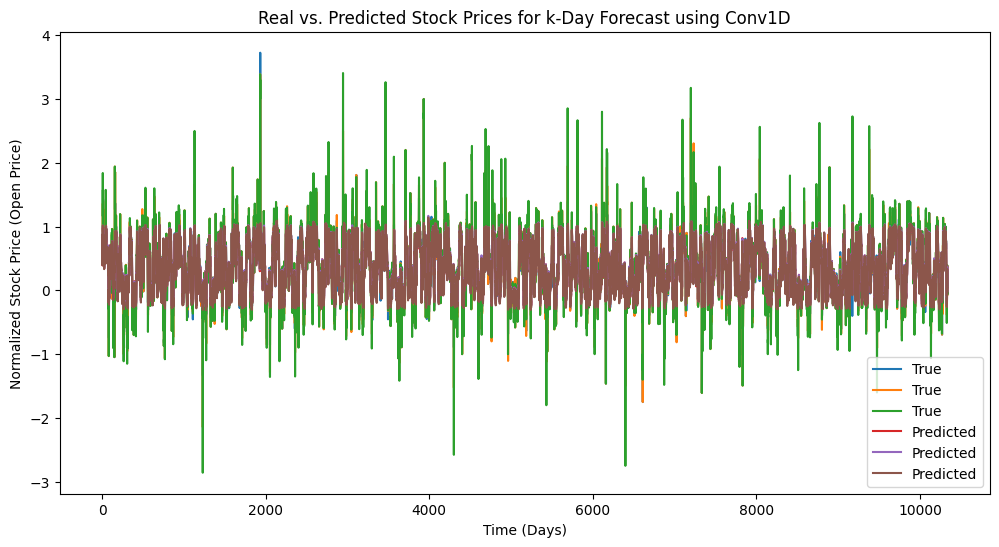

In [15]:
import matplotlib.pyplot as plt

# Plot the true and predicted stock prices for k-day forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_k_days_norm, label='True')  # True values for k-day ahead prediction
plt.plot(yhat_Conv1D, label='Predicted')    # Predicted values for k-day ahead
plt.title('Real vs. Predicted Stock Prices for k-Day Forecast using Conv1D')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Stock Price (Open Price)')
plt.legend()
plt.show()

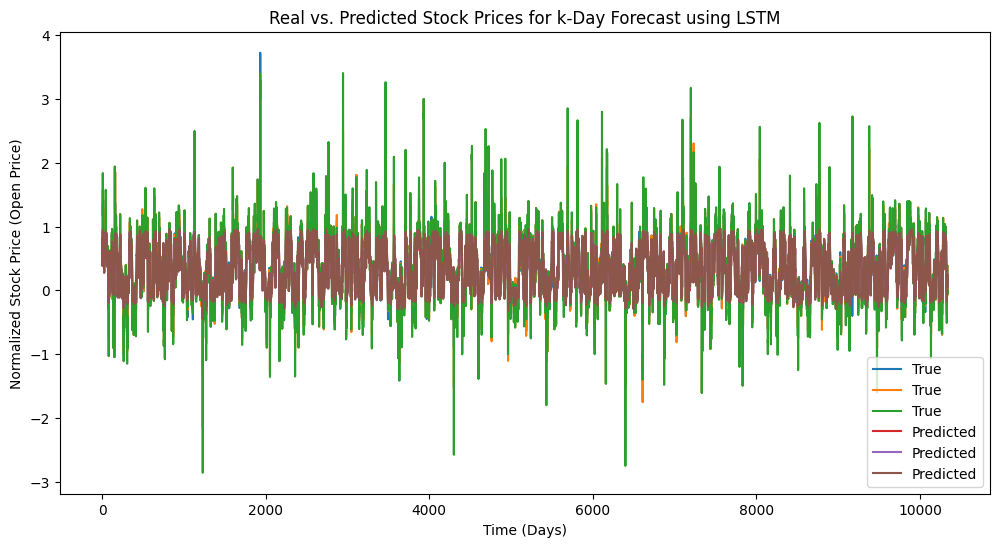

In [16]:
# Plot the true and predicted stock prices for k-day forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_k_days_norm, label='True')  # True values for k-day ahead prediction
plt.plot(yhat_LSTM, label='Predicted')    # Predicted values for k-day ahead
plt.title('Real vs. Predicted Stock Prices for k-Day Forecast using LSTM')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Stock Price (Open Price)')
plt.legend()
plt.show()

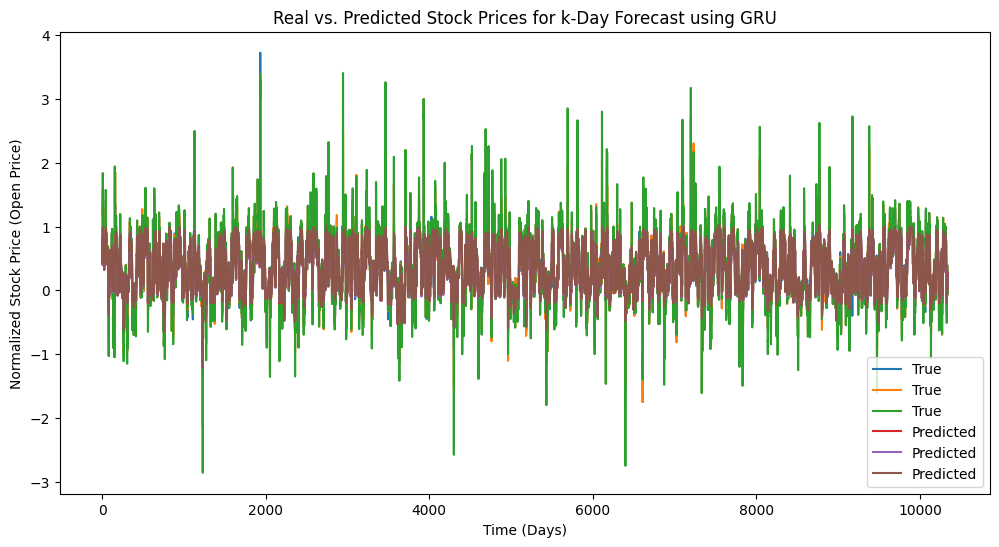

In [17]:
# Plot the true and predicted stock prices for k-day forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_k_days_norm, label='True')  # True values for k-day ahead prediction
plt.plot(yhat_GRU, label='Predicted')    # Predicted values for k-day ahead
plt.title('Real vs. Predicted Stock Prices for k-Day Forecast using GRU')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Stock Price (Open Price)')
plt.legend()
plt.show()

Using modelLSTM for prediction


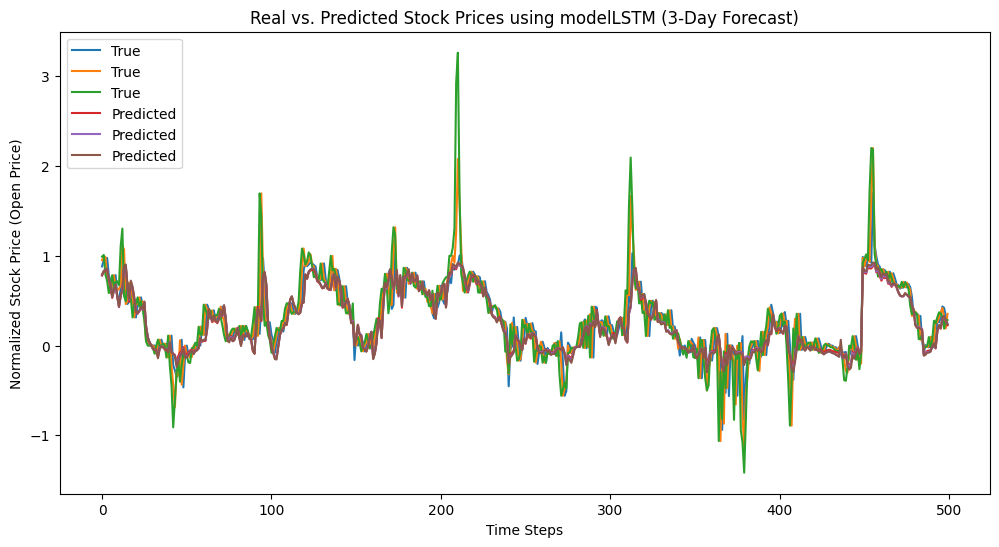

In [28]:
import random
import matplotlib.pyplot as plt

# Dictionary of models
models = {
    "modelConv1D": model,
    "modelLSTM": modelLSTM,
    "modelGRU": modelGRU
}

# Randomly select a model for prediction
selected_model_name = random.choice(list(models.keys()))
selected_model = models[selected_model_name]
print(f"Using {selected_model_name} for prediction")

# Select a random index from the list of DataFrames
random_index = random.randint(0, len(df_list) - 1)
random_file = df_list[random_index]  # Get the DataFrame
file_name = keywords[random_index]  # Get the corresponding file name
file_name_prefix = file_name[:3]  # Extract the first 3 letters

# Print the file name prefix
# print(f"Randomly selected company file prefix: {file_name_prefix}")

# Make predictions with the selected model for the k-day forecast
yhat_k_days = selected_model.predict(X_test_k_days_norm)

# Select a random starting index for the 30-day subset
random_index = random.randint(0, len(y_test_k_days_norm) - 500)

# Plot the true and predicted stock prices for the selected company
plt.figure(figsize=(12, 6))
plt.plot(y_test_k_days_norm[random_index:random_index + 500], label='True')
plt.plot(yhat_k_days[random_index:random_index + 500], label='Predicted')
plt.title(f"Real vs. Predicted Stock Prices using {selected_model_name} (3-Day Forecast)")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Stock Price (Open Price)")
plt.legend()
plt.show()